In [4]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn import preprocessing
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [5]:
def plot_train_vs_test(train_scores, test_scores, points = {}, time = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")
    plt.show()

    maxarg = list(test_scores.keys())[np.argmax(list(test_scores.values()))]
    print("AT", maxarg, test_scores[maxarg], "WITH", len(points), "ITERATIONS IN", time, "SECONDS")

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [6]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1600])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1600])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random Selection

In [7]:
@time_func
def RANDOM_SELECTION(CVal = 10):
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

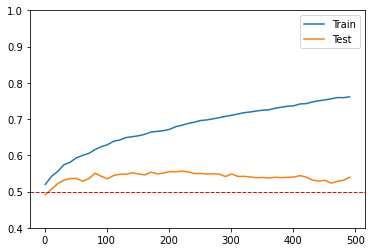

AT 221 0.5565 WITH 0 ITERATIONS IN -1 SECONDS
__main__.RANDOM_SELECTION - 00:00:16.481463300


In [8]:
RANDOM_SELECTION()

# SVM-RFE

In [9]:
@time_func
def SVM_RFE_NO_STEP():
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, 1) for test_index, train_index in kf.split(data.X_train)]
    with Pool(6) as pool:
        scores = pool.map(data.svm_rfe, index)

    #scores = list(map(data.svm_rfe, index))

    scores = list(scores)
    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, {}, time)

In [10]:
#SVM_RFE_NO_STEP()

# SVM-RFE with Step


In [11]:
@time_func
def SVM_RFE_W_STEP(step):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, step) for test_index, train_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe, index)

    # scores = list(map(data.svm_rfe, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, points, time)

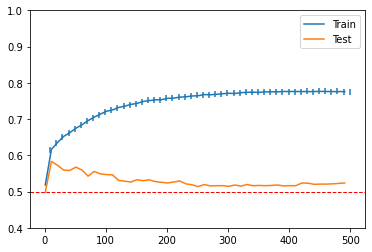

AT 11 0.5831250000000001 WITH 50 ITERATIONS IN 10.058045637607574 SECONDS
__main__.SVM_RFE_W_STEP - 00:01:03.680716400


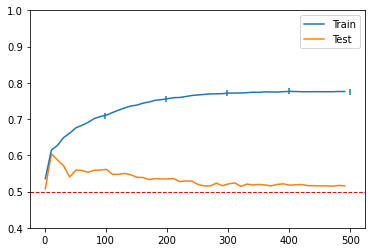

AT 11 0.6043749999999999 WITH 5 ITERATIONS IN 1.213654386997223 SECONDS
__main__.SVM_RFE_W_STEP - 00:00:37.787726300


In [12]:
#SVM_RFE_W_STEP(2)
#SVM_RFE_W_STEP(5)
SVM_RFE_W_STEP(10)
#SVM_RFE_W_STEP(50)
SVM_RFE_W_STEP(100)
#SVM_RFE_W_STEP(200)
#SVM_RFE_W_STEP(300)

# SVM-RFE with DynamicStep

In [15]:
@time_func
def SVM_RFE_W_DSTEP(percentage, stop = 1):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, percentage, stop) for test_index, train_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_dynamic_step, index)
        scores = list(scores)

    # scores = list(map(data.svm_rfe, index))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, points, time)

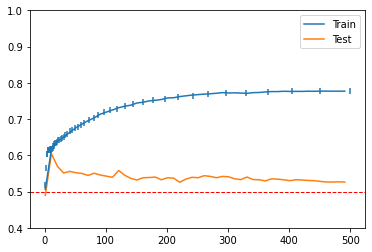

AT 11 0.604375 WITH 52 ITERATIONS IN 3.5659988641738893 SECONDS
__main__.SVM_RFE_W_DSTEP - 00:00:43.047302400


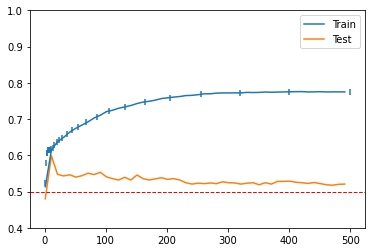

AT 11 0.59875 WITH 28 ITERATIONS IN 1.7890164256095886 SECONDS
__main__.SVM_RFE_W_DSTEP - 00:00:38.197560300


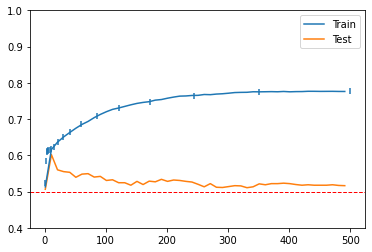

AT 11 0.6018749999999999 WITH 19 ITERATIONS IN 1.16681467294693 SECONDS
__main__.SVM_RFE_W_DSTEP - 00:00:35.025930800


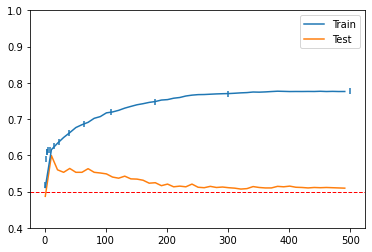

AT 11 0.599375 WITH 14 ITERATIONS IN 0.9190860748291015 SECONDS
__main__.SVM_RFE_W_DSTEP - 00:00:35.592087300


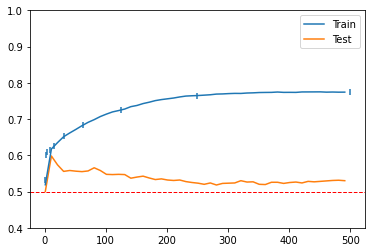

AT 11 0.598125 WITH 10 ITERATIONS IN 0.7546933650970459 SECONDS
__main__.SVM_RFE_W_DSTEP - 00:00:35.199344500


In [16]:
SVM_RFE_W_DSTEP(0.1)
SVM_RFE_W_DSTEP(0.2)
SVM_RFE_W_DSTEP(0.3)
SVM_RFE_W_DSTEP(0.4)
SVM_RFE_W_DSTEP(0.5)

# SVM-RFE with DynamicStep based Plotting

In [19]:
@time_func
def SVM_RFE_W_DSTEP_PLOT(percentage, stop=1):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, percentage, stop) for test_index, train_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_dynamic_step_only, index)
        scores= list(scores)

    # result = list(map(data.svm_rfe_dynamic_step_only, index))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, points, time)

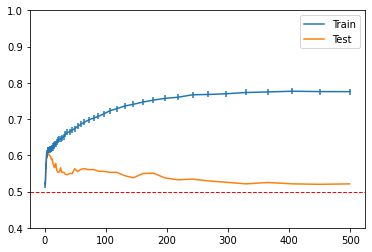

AT 6 0.6056250000000001 WITH 52 ITERATIONS IN 3.5282191753387453 SECONDS
__main__.SVM_RFE_W_DSTEP_PLOT - 00:00:12.579445900


In [20]:
SVM_RFE_W_DSTEP_PLOT(0.1)

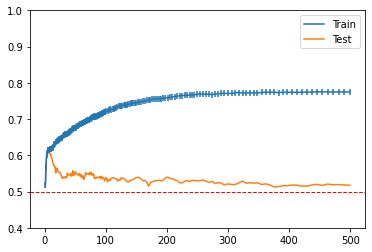

AT 7 0.61125 WITH 190 ITERATIONS IN 18.874201345443726 SECONDS
__main__.SVM_RFE_W_DSTEP_PLOT - 00:00:58.889525500


In [23]:
SVM_RFE_W_DSTEP_PLOT(0.02, 1)

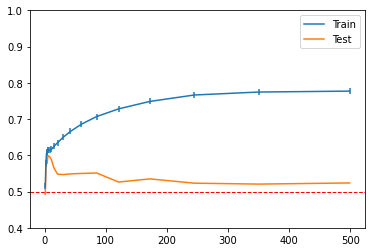

AT 6 0.59875 WITH 19 ITERATIONS IN 1.1914596557617188 SECONDS
__main__.SVM_RFE_W_DSTEP_PLOT - 00:00:05.851435500


In [24]:
SVM_RFE_W_DSTEP_PLOT(0.3, 1)